A. Definicion de Objetivo
    En el presente proyecto, se muestra el analisis de datos de la corporacion Favorita, uno de los supermercados mas grandes de Ecuador. Se busca predecir las ventas de los productos de dicha empresa. Se empzara por cargar los datos, entenderlos, limpiarlos, y cargarlos a un modelo para poder predecir las ventas.

In [57]:
# Proyecto Final Ciencia de Datos:
# Equipo:
# Regina Crespo Oliver
# Abraham Emilio García Ponce
# Lucio Maldonado
# Daniel Zapata
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn as sk
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [58]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
stores=pd.read_csv("stores.csv")
oil=pd.read_csv("oil.csv")
holidays=pd.read_csv("holidays_events.csv")

In [59]:
train.describe() # Datos estadisticos de los datos de entrenamiento.

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [60]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


Con los datos es posible ver que hay diferentes maneras de predecir las ventas, como puede ser mediante la fecha, tienda que lo vende, o el producto.
Posibilidades: Dias de las semana, agrupar las tiendas en clusters.

In [61]:
# Primero, vamos a limpiar los datos y convertirlo a dias de la semana.

def dates(var_df): #esta funcion transforma la columna de date de un dataframe a dias de la semana 0-6.
    days=pd.to_datetime(var_df["date"])
    week=days.dt.dayofweek
    month=days.dt.month
    var_df["day_of_week"]=week
    var_df["month"]=month
    return var_df

def payroll_period(var_df):
    days=pd.to_datetime(var_df["date"])
    payroll=days.dt.is_month_end
    payroll=payroll.astype(int)
    days=days.dt.day
    days=days.where(days==15)
    days=days.replace(to_replace = [15], value=[1])
    payroll=days + payroll
    var_df["payroll"]=payroll
    var_df["payroll"]=var_df["payroll"].fillna(0)
    return var_df

train_dates=dates(train)
train_dates=payroll_period(train_dates)
train_dates

,id,date,store_nbr,family,sales,onpromotion,day_of_week,month,payroll
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,1,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,1,1,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,1,1,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,1,1,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,1,8,1.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1,8,1.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,1,8,1.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,1,8,1.0


Ahora, seria bueno sustituir los sotre_nbr con los clusters de las tiendas disponibles en la variable "stores". Esto para reducir aun mas los datos y que sean mas significativos.

In [62]:
def store_to_cluster(df_to_cluster,cluster): #esta funcion agrega los clusters de tienda a nuestro dataframe
    test=df_to_cluster.join(cluster[["store_nbr","cluster"]].set_index("store_nbr"), on="store_nbr")
    return test

train_ready=store_to_cluster(train_dates,stores)
train_ready.head()

,id,date,store_nbr,family,sales,onpromotion,day_of_week,month,payroll,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,0.0,13
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,0.0,13
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,0.0,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,0.0,13
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,0.0,13


Finalmente, hay que realizar un encoding de la columna de family, clusters y day_of_week para que sea mas facil, que la computadora entienda los datos de la base de datos.

In [63]:
def encode_fun(df,col,pre=""): #esta funcion nos ayuda a encodear un dataframe, tomando como referenica una dataframe, columna, y un prefijo (OPCIONAL). EL prefijo ayuda a identificar la columna.
    encoder=OneHotEncoder()
    df_reshaped=np.array(df[col]).reshape(-1,1)
    df_values=encoder.fit_transform(df_reshaped)
    new_cols=[pre + str(x) for x in encoder.categories_[0]]
    df_col=pd.DataFrame(data=df_values.toarray(),columns=new_cols)
    df_final=pd.concat([df,df_col],axis=1)
    return df_final

In [64]:
#Encodeamos todas las variables (columnas)
train_test=encode_fun(train_ready,"family")
train_test=encode_fun(train_test,"day_of_week",pre="DAY")
train_test=encode_fun(train_test,"cluster",pre="C")
train_test=encode_fun(train_test,"month",pre="MONTH")

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [65]:
train_test.head()

,id,date,store_nbr,family,sales,onpromotion,day_of_week,month,payroll,cluster,...,MONTH3.0,MONTH4.0,MONTH5.0,MONTH6.0,MONTH7.0,MONTH8.0,MONTH9.0,MONTH10.0,MONTH11.0,MONTH12.0
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,0.0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,0.0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,0.0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,0.0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,0.0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
train_final=train_test
train_final=train_final.drop(columns=["family","date","store_nbr","cluster","day_of_week","month"]) #dropeamos las columnas que no necesitamos
train_final.head()

,id,sales,onpromotion,payroll,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,...,MONTH3.0,MONTH4.0,MONTH5.0,MONTH6.0,MONTH7.0,MONTH8.0,MONTH9.0,MONTH10.0,MONTH11.0,MONTH12.0
0,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
#RC
#Ahora sigue repetir el proceso anterior pero ahora con los datos de test

test_weekly=dates(test)
test_weekly=payroll_period(test_weekly)
test_weekly

,id,date,store_nbr,family,onpromotion,day_of_week,month,payroll
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2,8,0.0
1,3000889,2017-08-16,1,BABY CARE,0,2,8,0.0
2,3000890,2017-08-16,1,BEAUTY,2,2,8,0.0
3,3000891,2017-08-16,1,BEVERAGES,20,2,8,0.0
4,3000892,2017-08-16,1,BOOKS,0,2,8,0.0
...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,3,8,0.0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,3,8,0.0
28509,3029397,2017-08-31,9,PRODUCE,1,3,8,0.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,3,8,0.0


In [68]:
#RC
test_ready=store_to_cluster(test_weekly,stores)

In [69]:
#RC
test_test=encode_fun(test_ready,"family")
test_test=encode_fun(test_test,"day_of_week",pre="DAY")
test_test=encode_fun(test_test,"cluster",pre="C")
test_test=encode_fun(test_test,"month",pre="MONTH")

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [70]:
#RC
test_test.head()

,id,date,store_nbr,family,onpromotion,day_of_week,month,payroll,cluster,AUTOMOTIVE,...,C9.0,C10.0,C11.0,C12.0,C13.0,C14.0,C15.0,C16.0,C17.0,MONTH8.0
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2,8,0.0,13,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3000889,2017-08-16,1,BABY CARE,0,2,8,0.0,13,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3000890,2017-08-16,1,BEAUTY,2,2,8,0.0,13,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3000891,2017-08-16,1,BEVERAGES,20,2,8,0.0,13,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3000892,2017-08-16,1,BOOKS,0,2,8,0.0,13,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [71]:
#RC
test_final=test_test
test_final=test_final.drop(columns=["family","date","store_nbr","cluster","day_of_week","month"])
#al final tambien tenemos que añadir todas las columnas de month que no vienen incluidas 
for col in train_final.columns :
  if col in test_final:
    pass
  else:
    test_final[str(col)]=0
test_final

,id,onpromotion,payroll,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,...,MONTH2.0,MONTH3.0,MONTH4.0,MONTH5.0,MONTH6.0,MONTH7.0,MONTH9.0,MONTH10.0,MONTH11.0,MONTH12.0
0,3000888,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3000889,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3000890,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3000891,20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3000892,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28508,3029396,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28509,3029397,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28510,3029398,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1)
m.fit(train_final.drop('sales', axis=1), train_final.sales)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [73]:
m.score(train_final.drop('sales', axis=1), train_final.sales)

0.9755207986255804

In [74]:
test_predict = test_final
test_predict["sales"]=m.predict(test_final.drop('sales', axis=1))

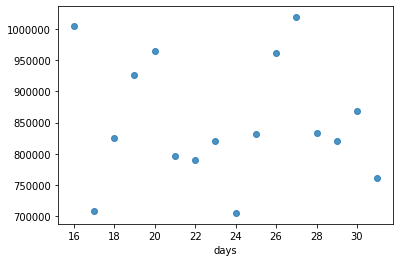

In [75]:
test_days=pd.to_datetime(test["date"])
test_days=test_days.dt.day
test_predict["days"]=test_days
test_days=test_predict[["days","sales"]]

test["sales"]=test_predict["sales"]
test = test.drop(columns = ['date','store_nbr','family','onpromotion','day_of_week','month','payroll'])
test = test.set_index('id')
test.to_csv("Results.csv")

sb.regplot(x=test_days["days"].drop_duplicates(),y=test_days.groupby(by=["days"]).sum(),fit_reg=False)

In [76]:
test

,sales
id,
3000888,7.200000
3000889,0.000000
3000890,7.480000
3000891,3397.600000
3000892,0.000000
...,...
3029395,238.488024
3029396,122.532160
3029397,898.512280
